In [1]:
import itertools
import logging
import warnings

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq 

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
#from pandas.tseries.offsets import DateOffset

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"

warnings.filterwarnings("ignore")
logger = logging.getLogger()
#logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.ERROR)


/Users/evan/.pyenv/versions/3.11.5/envs/ds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def query_ticker_data():
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_history`
        ORDER BY date
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df

In [3]:
all = query_ticker_data().set_index('date')

In [4]:
apple = all[all['ticker'] == 'AAPL']
netflix = all[all['ticker'] == 'NFLX']
microsoft = all[all['ticker'] == 'MSFT']
amazon = all[all['ticker'] == 'AMZN']
alphabet = all[all['ticker'] == 'GOOGL']
coke = all[all['ticker'] == 'KO']

In [5]:
apple.name = "Apple"
netflix.name = "Netflix"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [25]:
TARGET_DF = netflix

In [26]:
vwap = TARGET_DF['volume_weighted_average_price']

In [27]:
TARGET_DF['simple_rtn'] = vwap.pct_change()
TARGET_DF['log_rtn'] = np.log(vwap/vwap.shift(1))

[Text(0, 0.5, 'Simple returns (%)')]

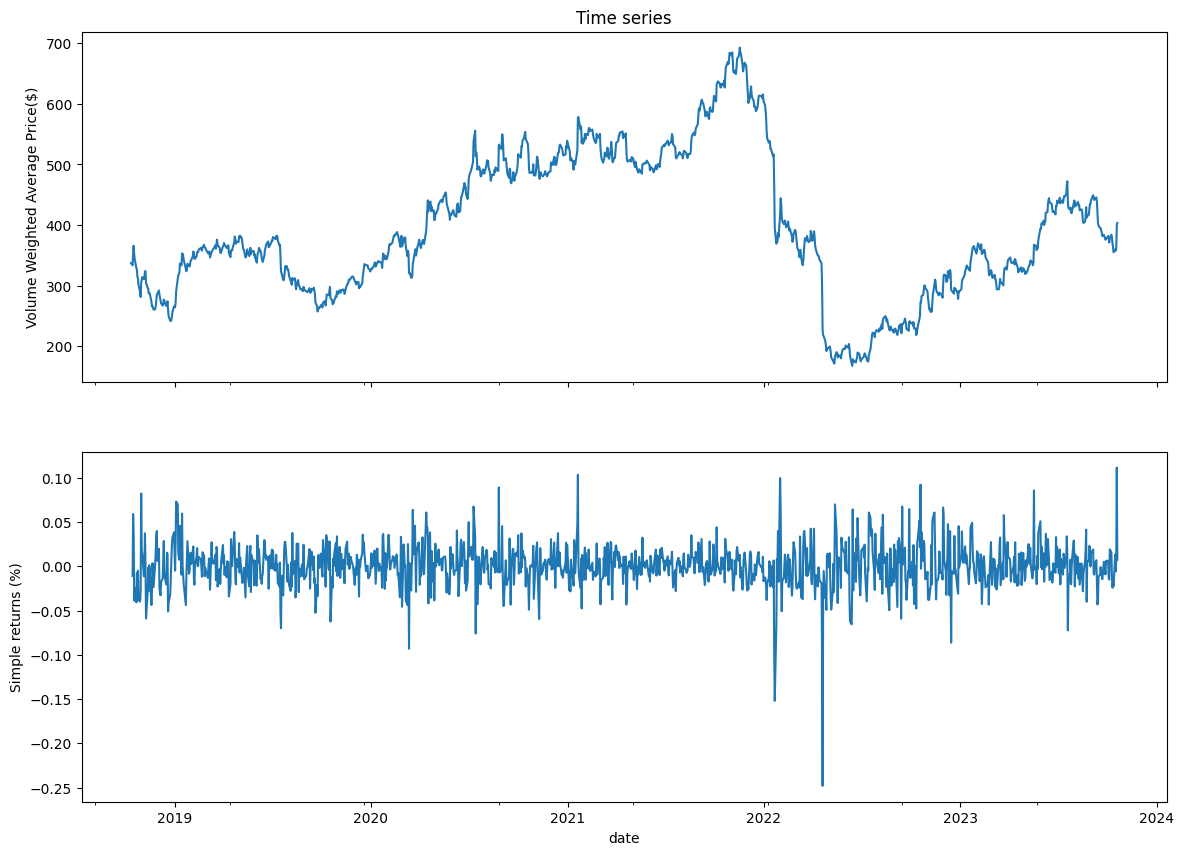

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
vwap.plot(ax=ax[0])
ax[0].set(title = 'Time series', ylabel = 'Volume Weighted Average Price($)')
TARGET_DF.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

In [29]:
hist = TARGET_DF[['volume_weighted_average_price']]
hist.reset_index(level=0, inplace=True)
hist = hist.rename({'date': 'ds', 'volume_weighted_average_price': 'y'}, axis='columns')

In [30]:
param_grid = { 
    "daily_seasonality": [False],
    "weekly_seasonality": [False],
    "yearly_seasonality": [False, True],
    "growth": ["linear"],
    "seasonality_mode": ["additive", "multiplicative"],    
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    #m= m.add_seasonality(name="quarterly", period=63, fourier_order=10)
    #m.add_country_holidays("US")
    m = m.fit(hist)  # Fit model with given params
    df_cv = cross_validation(m, initial='1095 days', period='63 days', horizon = '252 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

19:02:33 - cmdstanpy - INFO - Chain [1] start processing
19:02:34 - cmdstanpy - INFO - Chain [1] done processing
19:02:35 - cmdstanpy - INFO - Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] done processing
19:02:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:02:35 - cmdstanpy - INFO - Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] done processing
19:02:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
19:02:35 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
19:02:35 - cmdstanpy - INFO - Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] done processing
19:02:35 - cmdstanpy - ERROR - Chain [1] error: error during proc

,daily_seasonality,weekly_seasonality,yearly_seasonality,growth,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,rmse
0,False,False,False,linear,additive,0.001,0.01,263.149010
1,False,False,False,linear,additive,0.001,0.10,263.149010
2,False,False,False,linear,additive,0.001,1.00,263.149010
3,False,False,False,linear,additive,0.001,10.00,263.149010
4,False,False,False,linear,additive,0.010,0.01,309.268413
...,...,...,...,...,...,...,...,...
59,False,False,True,linear,multiplicative,0.100,10.00,293.286106
60,False,False,True,linear,multiplicative,0.500,0.01,303.580510
61,False,False,True,linear,multiplicative,0.500,0.10,258.882806
62,False,False,True,linear,multiplicative,0.500,1.00,256.535544


In [31]:
# Python
best_params = all_params[np.argmin(rmses)]
best_params

{'daily_seasonality': False,
 'weekly_seasonality': False,
 'yearly_seasonality': True,
 'growth': 'linear',
 'seasonality_mode': 'multiplicative',
 'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 1.0}

19:05:23 - cmdstanpy - INFO - Chain [1] start processing
19:05:23 - cmdstanpy - INFO - Chain [1] done processing


Predicted Data
             ds        yhat  yhat_lower  yhat_upper
1260 2023-10-17  404.406242  374.628320  432.088052
1261 2023-10-18  404.631014  377.404497  432.738794
1262 2023-10-19  404.741110  375.301344  431.843143
1263 2023-10-20  404.745964  378.295001  435.033929
1264 2023-10-23  404.264673  376.348527  432.696250
1265 2023-10-24  403.995041  373.340506  432.537820
1266 2023-10-25  403.702645  376.372761  432.795871
1267 2023-10-26  403.407780  376.225245  432.464244
1268 2023-10-27  403.130795  375.708531  431.851549
1269 2023-10-30  402.600381  376.337125  430.187961


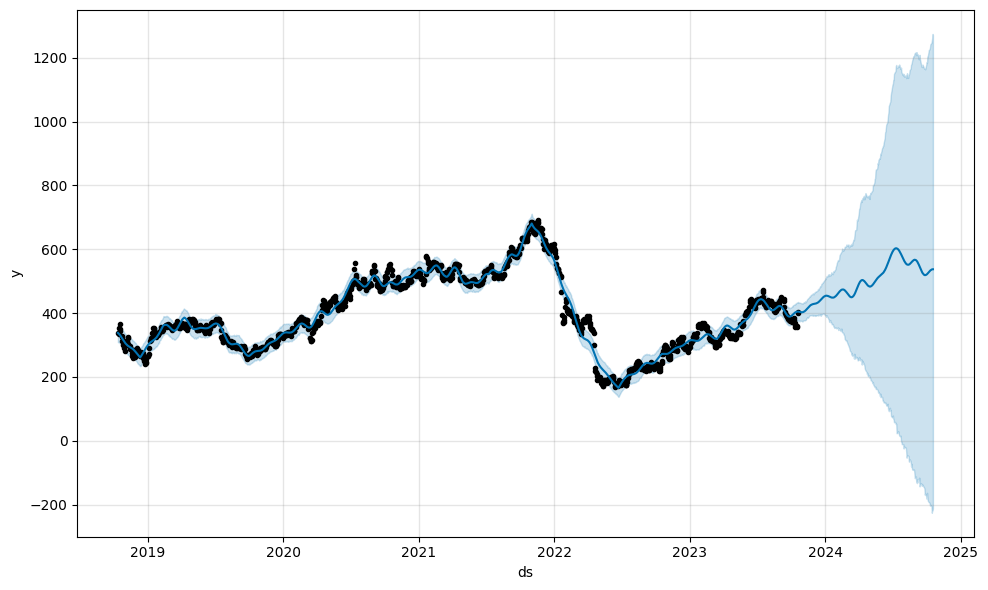

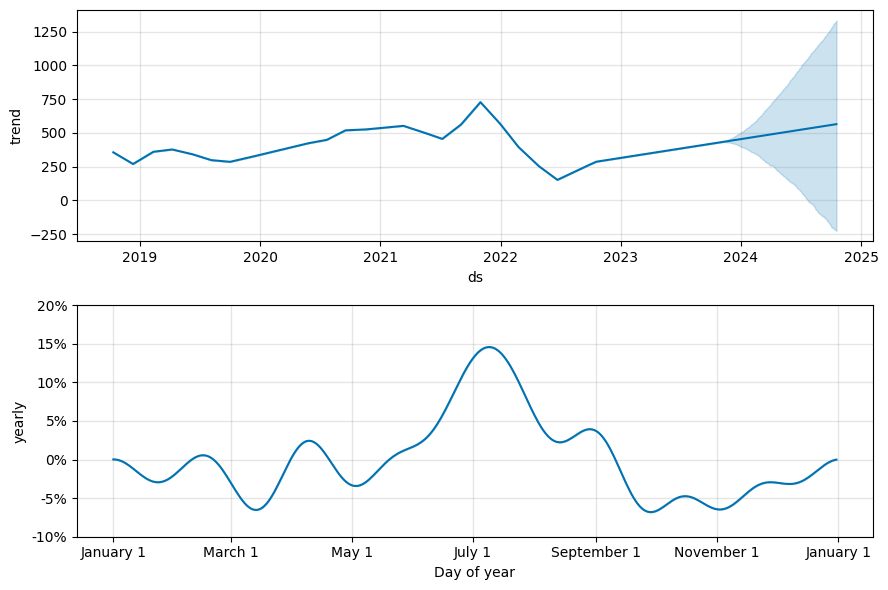

In [32]:
"""
param ={
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "growth": "linear",
    "seasonality_mode": "additive",
    'changepoint_prior_scale': 0.01, 
    'seasonality_prior_scale': 10.0
}
"""

m = Prophet(**best_params)
#m= m.add_seasonality(name="monthly", period=30, fourier_order=10)
#m= m.add_seasonality(name="quarterly", period=63, fourier_order=10)
#m.add_country_holidays("US")
m.fit(hist)
future = m.make_future_dataframe(periods=365, freq='D')
future = future[future['ds'].dt.dayofweek < 5]
forecast = m.predict(future)
print("Predicted Data")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[1260:1270])
figure1 = m.plot(forecast)
figure2 = m.plot_components(forecast)

#plot_plotly(m, forecast, figsize=(1000,600)) # 
#plot_components_plotly(m, forecast, figsize=(1000,600))

In [33]:
df_cv = cross_validation(m, initial='1095 days', period='90 days', horizon = '365 days', parallel="processes")

19:05:25 - cmdstanpy - INFO - Chain [1] start processing
19:05:25 - cmdstanpy - INFO - Chain [1] start processing
19:05:25 - cmdstanpy - INFO - Chain [1] start processing
19:05:25 - cmdstanpy - INFO - Chain [1] start processing
19:05:25 - cmdstanpy - INFO - Chain [1] start processing
19:05:25 - cmdstanpy - INFO - Chain [1] done processing
19:05:25 - cmdstanpy - INFO - Chain [1] done processing
19:05:25 - cmdstanpy - INFO - Chain [1] done processing
19:05:26 - cmdstanpy - INFO - Chain [1] done processing
19:05:26 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,6237.970091,78.980821,72.082659,0.279133,0.218706,0.271408,0.088
1,37 days,6144.409792,78.386286,71.404512,0.277061,0.217129,0.269535,0.096
2,38 days,6011.659674,77.534893,70.711552,0.276200,0.217129,0.270185,0.104
3,39 days,5884.945404,76.713398,70.065722,0.274153,0.196042,0.269694,0.104
4,40 days,5830.777506,76.359528,69.816262,0.274266,0.217129,0.271221,0.104
...,...,...,...,...,...,...,...,...
325,361 days,213323.000494,461.869030,402.296381,1.221252,1.298578,1.273335,1.000
326,362 days,213938.799121,462.535187,402.876364,1.217022,1.311799,1.279613,1.000
327,363 days,215663.309941,464.395639,405.501601,1.222119,1.311799,1.291447,1.000
328,364 days,219890.798705,468.925153,411.375663,1.240888,1.325684,1.300736,1.000


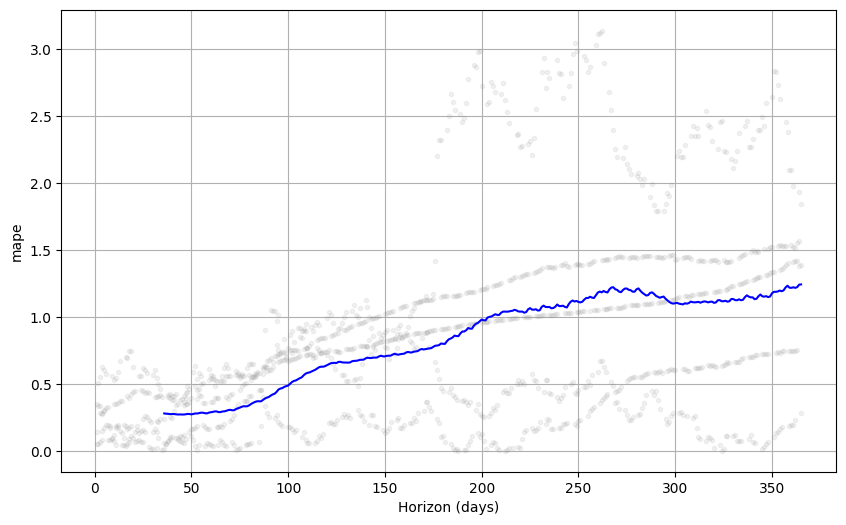

In [35]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [36]:
duckdb.sql("select cutoff, count(*) from df_cv group by 1 order by 1").df()

,cutoff,count_star()
0,2021-10-25,252
1,2022-01-23,251
2,2022-04-23,250
3,2022-07-22,250
4,2022-10-20,251


In [38]:
df_overlap = df_cv[df_cv.cutoff=="2022-10-20"]
df_overlap['diff'] =  np.square(df_overlap['yhat']- df_overlap['y'])

In [41]:
duckdb.sql("SELECT sqrt(sum(diff)/count(*)) as RMSE from df_overlap").df()

,RMSE
0,350.83422
